In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
tf.Session(config=config)

import keras
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import *
from keras.backend import tf as ktf
from keras.callbacks import EarlyStopping
from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import csv
import os
from PIL import Image
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style()

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(224, 224),
        class_mode='categorical'
)

Found 4750 images belonging to 12 classes.


In [2]:
# X_train = np.load('data/preprocessed/X_train_woseg.npy')
# Y_train = np.load('data/preprocessed/Y_train_woseg.npy')
# X_test = np.load('data/preprocessed/X_test_woseg.npy')
X_train = np.load('data/preprocessed/X_train.npy')
Y_train = np.load('data/preprocessed/Y_train.npy')
X_test = np.load('data/preprocessed/X_test.npy')

X_train.shape, Y_train.shape, X_test.shape

((4750, 224, 224, 3), (4750, 12), (794, 224, 224, 3))

In [17]:
X_train /= 255
X_test /= 255

In [3]:
#shuffle the data
idx = np.random.permutation(len(X_train))
X_train,Y_train = X_train[idx], Y_train[idx]

#### Utility functions

In [4]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1,)
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(' accuracy')


    plt.subplot(1, 2, 2)
    
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('loss')
    plt.show()

### CNNs

In [22]:
def seqModel():
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), input_shape=(224, 224, 3)))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    model.add(Conv2D(16, (3, 3)))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))

    model.add(Conv2D(32, (3, 3)))
#     model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
#     model.add(GlobalMaxPooling2D())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(Activation('relu'))
#     model.add(BatchNormalization())
    
    model.add(Dropout(0.2))
    
    model.add(Dense(12))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [23]:
cnnmodel = seqModel()

In [24]:
cnnmodel_history = cnnmodel.fit(X_train, Y_train, batch_size=30, epochs=20, validation_split=0.2, shuffle=True,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1)])

Train on 3800 samples, validate on 950 samples
Epoch 1/20
3800/3800 [==============================] - 38s 10ms/step - loss: 1.5718 - acc: 0.5237 - val_loss: 2.0379 - val_acc: 0.5221
Epoch 2/20
3800/3800 [==============================] - 34s 9ms/step - loss: 0.8191 - acc: 0.7279 - val_loss: 2.0875 - val_acc: 0.5347
Epoch 3/20
3800/3800 [==============================] - 34s 9ms/step - loss: 0.5321 - acc: 0.8124 - val_loss: 2.6792 - val_acc: 0.5011
Epoch 4/20
3800/3800 [==============================] - 34s 9ms/step - loss: 0.3763 - acc: 0.8711 - val_loss: 1.6597 - val_acc: 0.5663
Epoch 5/20
3800/3800 [==============================] - 35s 9ms/step - loss: 0.2876 - acc: 0.8987 - val_loss: 1.5708 - val_acc: 0.6558
Epoch 6/20
3800/3800 [==============================] - 35s 9ms/step - loss: 0.2047 - acc: 0.9311 - val_loss: 1.3723 - val_acc: 0.6453
Epoch 7/20
3800/3800 [==============================] - 35s 9ms/step - loss: 0.1828 - acc: 0.9345 - val_loss: 1.7486 - val_acc: 0.7116
Epoch 8

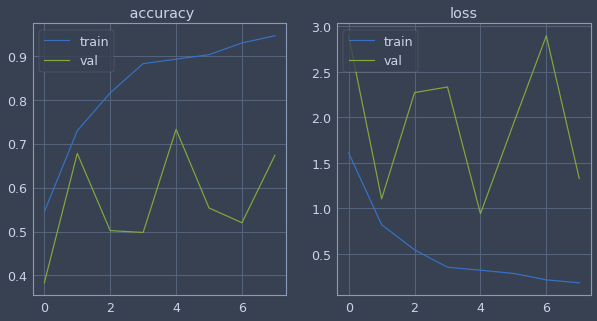

In [11]:
plot_training(cnnmodel_history)

## Transfer Learning

In [10]:
inception_model = InceptionV3(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

In [11]:
inc_train_bf = inception_model.predict(X_train, verbose=1)
inc_test_bf = inception_model.predict(X_test, verbose=1)

794/794 [==============================] - 6s 7ms/step


In [69]:
def top_model(input_shape):
    input_img = Input(input_shape)
    X = GlobalAveragePooling2D()(input_img)
#     X = Flatten(input_shape=input_shape)(input_img)
#     X = Dropout(0.5)(X)   
    
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.5)(X)
    
#     X = Dense(1024, activation='relu')(X)
#     X = Dropout(0.5)(X)
        
    X = Dense(12, activation='softmax')(X)
    
    model = Model(inputs=input_img, outputs=X)
    
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',#optimizers.SGD(lr=1e-4, momentum=0.9),#'adam',
                 metrics=['accuracy'])
    
    return model

In [70]:
inctop_model = top_model(inc_train_bf.shape[1:])

In [71]:
inc_history = inctop_model.fit(inc_train_bf, Y_train, batch_size=100, epochs=50, validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_acc', patience=3, verbose=1)])

Train on 3800 samples, validate on 950 samples
Epoch 1/50
3800/3800 [==============================] - 7s 2ms/step - loss: 3.2595 - acc: 0.1971 - val_loss: 2.0739 - val_acc: 0.3032
Epoch 2/50
3800/3800 [==============================] - 1s 271us/step - loss: 2.1271 - acc: 0.2716 - val_loss: 1.8776 - val_acc: 0.3474
Epoch 3/50
3800/3800 [==============================] - 1s 274us/step - loss: 2.0325 - acc: 0.3018 - val_loss: 1.7933 - val_acc: 0.3779
Epoch 4/50
3800/3800 [==============================] - 1s 282us/step - loss: 1.9379 - acc: 0.3171 - val_loss: 1.6942 - val_acc: 0.3895
Epoch 5/50
3800/3800 [==============================] - 1s 277us/step - loss: 1.8746 - acc: 0.3324 - val_loss: 1.6951 - val_acc: 0.4147
Epoch 6/50
3800/3800 [==============================] - 1s 281us/step - loss: 1.8614 - acc: 0.3271 - val_loss: 1.6222 - val_acc: 0.4537
Epoch 7/50
3800/3800 [==============================] - 1s 275us/step - loss: 1.8178 - acc: 0.3463 - val_loss: 1.5434 - val_acc: 0.5021
Epo

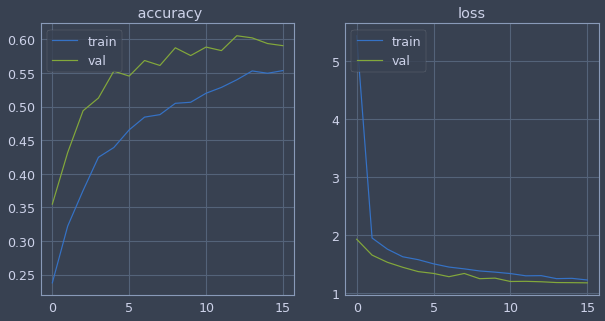

In [56]:
plot_training(inc_history)

### Prediction 

In [31]:
test = pd.read_csv('sample_submission.csv')

In [33]:
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [64]:
# preds = cnnmodel.predict(X_test, verbose=1, batch_size=5)
preds = inctop_model.predict(inc_test_bf, verbose=1, batch_size=50)

sub = pd.DataFrame(test)
sub['species'] = np.argmax(preds, axis=1)
sub['species'] = sub['species'].apply(lambda x: categories[x])
sub.to_csv('sub.csv', index=False)

794/794 [==============================] - 3s 3ms/step
